# Rodriguez model explanations

## First we need dataframes for every subject

In [22]:
import sys
sys.path.append('../')

%matplotlib inline

# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import pandas as pd
import numpy as np
import utils

pd.set_option('max_colwidth', 800) 

# DEFINE GRAPH
from importlib import reload
reload(utils)


<module 'utils' from '/Users/sbroome/Documents/EquineML/painface-recognition/notebooks/utils.py'>

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
# Data paths
rgb_path = '../data/jpg_128_128_2fps/'
of_path = 'no'

# Hyperparameters
input_width = 128
input_height = 128
seq_length = 10
seq_stride = 10
batch_size = 1
COLOR = True
nb_labels = 2

# Data augmentation
aug_flip = 0
aug_crop = 0
aug_light = 0

subject_ids = pd.read_csv('../metadata/horse_subjects.csv')['Subject'].values
channels = 3

In [5]:
from utils import ArgsProxy
args = ArgsProxy(rgb_path, of_path, input_height, input_width,
                 seq_length, seq_stride, batch_size, nb_labels,
                 aug_flip, aug_crop, aug_light)

In [6]:
import data_handler as dathand
dh = dathand.DataHandler(path=args.data_path,
                         of_path=args.of_path,
                         clip_list_file='videos_overview_missingremoved.csv',
                         data_columns=['Pain'],  # Here one can append f. ex. 'Observer'
                         image_size=(args.input_height, args.input_width),
                         seq_length=args.seq_length,
                         seq_stride=args.seq_stride,
                         batch_size=args.batch_size,
                         color=COLOR,
                         nb_labels=args.nb_labels,
                         aug_flip=args.aug_flip,
                         aug_crop=args.aug_crop,
                         aug_light=args.aug_light)

In [7]:
import utils
subject_dfs = utils.read_or_create_subject_dfs(dh, args, subject_ids)

../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/


In [8]:
sequence_df = utils.get_sequence(args=args, subject_dfs=subject_dfs, subject=4)
y = sequence_df['Pain'].values
image_paths = sequence_df['Path'].values

Chose subject  4
Start index in subject dataframe:  483


In [9]:
from keras.utils import np_utils
label_onehot = np_utils.to_categorical(y, num_classes=args.nb_labels)
batch_label = label_onehot.reshape(args.batch_size, -1)
batch_img = np.concatenate(utils.read_images_and_return_list(args, image_paths, 'local'), axis=1)

## Now that we have frames from all subjects, we can load the model we want to test.

In [10]:
# Choose a model to work on
best_model_path = '../models/BEST_MODEL_rodriguez_adadelta_LSTMunits_1024_CONVfilters_None_jpg128_2fps_val4_t1_seq10ss10_4hl_1024ubs16_no_aug_run2.h5'
import keras
m = keras.models.load_model(best_model_path)

In [11]:
m.layers

In [12]:
from keras import backend as K
import tensorflow as tf
    
images = tf.placeholder(tf.float32, [batch_size, args.seq_length, args.input_width, args.input_height, channels])
labels = tf.placeholder(tf.float32, [batch_size, args.seq_length, 2])
model = utils.RodriguezNetwork(images, path=best_model_path)

In [93]:
from keras import backend as k
listOfVariableTensors = m.trainable_weights
gradients = k.gradients(m(images), listOfVariableTensors)

[print(i,g) for i,g in enumerate(listOfVariableTensors)]
[print(i,g) for i,g in enumerate(gradients)]

0 <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32_ref>
1 <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32_ref>
2 <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>
3 <tf.Variable 'block1_conv2/bias:0' shape=(64,) dtype=float32_ref>
4 <tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>
5 <tf.Variable 'block2_conv1/bias:0' shape=(128,) dtype=float32_ref>
6 <tf.Variable 'block2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32_ref>
7 <tf.Variable 'block2_conv2/bias:0' shape=(128,) dtype=float32_ref>
8 <tf.Variable 'block3_conv1/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>
9 <tf.Variable 'block3_conv1/bias:0' shape=(256,) dtype=float32_ref>
10 <tf.Variable 'block3_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>
11 <tf.Variable 'block3_conv2/bias:0' shape=(256,) dtype=float32_ref>
12 <tf.Variable 'block3_conv3/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>
13 <tf.Variable 'block3_

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [13]:
sess = K.get_session()  # Grab the Keras session where the weights are initialized.

cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(model.preds)), axis=1)
print('model preds: ', model.preds)
print('cost: ', cost)
    
y_c = tf.reduce_sum(tf.multiply(model.preds, labels), axis=1)

print('y_c: ', y_c)

target_conv_layer = model.timedist_vgg # Choose which layer to study

print('tcl: ', target_conv_layer)
print('TYPE tcl: ', type(target_conv_layer))
    
target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

print('tclg: ', target_conv_layer_grad)
    
gb_grad = tf.gradients(cost, images)[0]  # Guided backpropagation back to input layer

model preds:  Tensor("dense_2_2/Sigmoid:0", shape=(1, 10, 2), dtype=float32)
cost:  Tensor("mul_1:0", shape=(1, 2), dtype=float32)
y_c:  Tensor("Sum_1:0", shape=(1, 2), dtype=float32)
tcl:  Tensor("input_1_2/Identity:0", shape=(1, 10, 128, 128, 3), dtype=float32)
TYPE tcl:  <class 'tensorflow.python.framework.ops.Tensor'>
tclg:  Tensor("gradients/time_distributed_1_2/transpose_grad/transpose:0", shape=(1, 10, 128, 128, 3), dtype=float32)


In [14]:
def run_on_one_sequence(sess, model, batch_img):
    with sess.as_default():
        prob = sess.run(model.preds,
                        feed_dict={images: batch_img,
                                   K.learning_phase(): 0})

        print(prob)
        # print(batch_label)
        gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
                      feed_dict={images: batch_img,
                      labels: batch_label,
                      K.learning_phase(): 0})
        target_conv_layer_value = np.reshape(target_conv_layer_value,
                                     (1, 10, 128, 128, 3))
        target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
                                     (1, 10, 128, 128, 3))


    utils.visualize_overlays(batch_img, target_conv_layer_value,
                       target_conv_layer_grad_value)


# Rodriguez predictions for subject 1

In [47]:
df = subject_dfs[0]
df.head()['Path']

0    data/jpg_128_128_2fps/horse_1/1_1a_1/frame_000001.jpg
1    data/jpg_128_128_2fps/horse_1/1_1a_1/frame_000002.jpg
2    data/jpg_128_128_2fps/horse_1/1_1a_1/frame_000003.jpg
3    data/jpg_128_128_2fps/horse_1/1_1a_1/frame_000004.jpg
4    data/jpg_128_128_2fps/horse_1/1_1a_1/frame_000005.jpg
Name: Path, dtype: object

Chose subject  1
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_1a/frame_001053.jpg     0
1  data/jpg_128_128_2fps/horse_2/2_1a/frame_001054.jpg     0
2  data/jpg_128_128_2fps/horse_2/2_1a/frame_001055.jpg     0
3  data/jpg_128_128_2fps/horse_2/2_1a/frame_001056.jpg     0
4  data/jpg_128_128_2fps/horse_2/2_1a/frame_001057.jpg     0
5  data/jpg_128_128_2fps/horse_2/2_1a/frame_001058.jpg     0
6  data/jpg_128_128_2fps/horse_2/2_1a/frame_001059.jpg     0
7  data/jpg_128_128_2fps/horse_2/2_1a/frame_001060.jpg     0
8  data/jpg_128_128_2fps/horse_2/2_1a/frame_001061.jpg     0
9  data/jpg_128_128_2fps/horse_2/2_1a/frame_001062.jpg     0
[[[0.9444868  0.06732056]
  [0.9665971  0.04004762]
  [0.9518204  0.04426664]
  [0.9312011  0.04675878]
  [0.9370468  0.03852168]
  [0.93847954 0.04309898]
  [0.9427332  0.04084516]
  [0.9437464  0.04290579]
  [0.9453686  0.04078801]
  [0.93986076 0.02841492]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


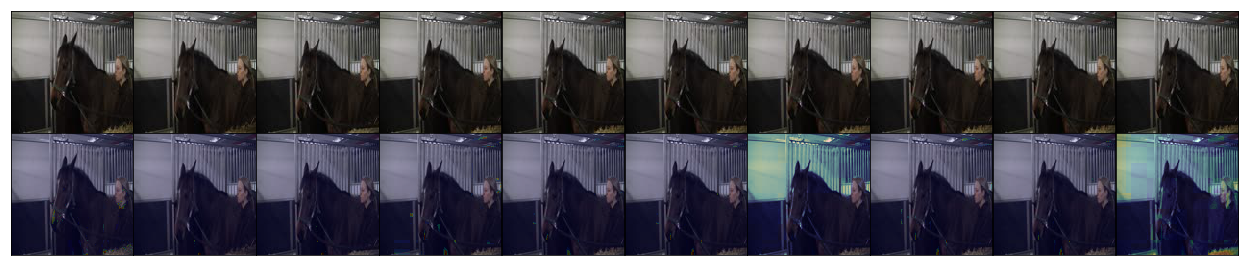

In [76]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
batch_img = np.array(batch_img, dtype=np.float32)
batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img)

Chose subject  1
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_2b/frame_000196.jpg     0
1  data/jpg_128_128_2fps/horse_2/2_2b/frame_000197.jpg     0
2  data/jpg_128_128_2fps/horse_2/2_2b/frame_000198.jpg     0
3  data/jpg_128_128_2fps/horse_2/2_2b/frame_000199.jpg     0
4  data/jpg_128_128_2fps/horse_2/2_2b/frame_000200.jpg     0
5  data/jpg_128_128_2fps/horse_2/2_2b/frame_000201.jpg     0
6  data/jpg_128_128_2fps/horse_2/2_2b/frame_000202.jpg     0
7  data/jpg_128_128_2fps/horse_2/2_2b/frame_000203.jpg     0
8  data/jpg_128_128_2fps/horse_2/2_2b/frame_000204.jpg     0
9  data/jpg_128_128_2fps/horse_2/2_2b/frame_000205.jpg     0
[[[0.9593728  0.02564008]
  [0.9841839  0.00848068]
  [0.98931307 0.01130569]
  [0.9904157  0.01009912]
  [0.9893939  0.00934849]
  [0.98844284 0.00755894]
  [0.98874205 0.0089793 ]
  [0.988467   0.00933343]
  [0.98670965 0.00941169]
  [0.9889465  0.00714208]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


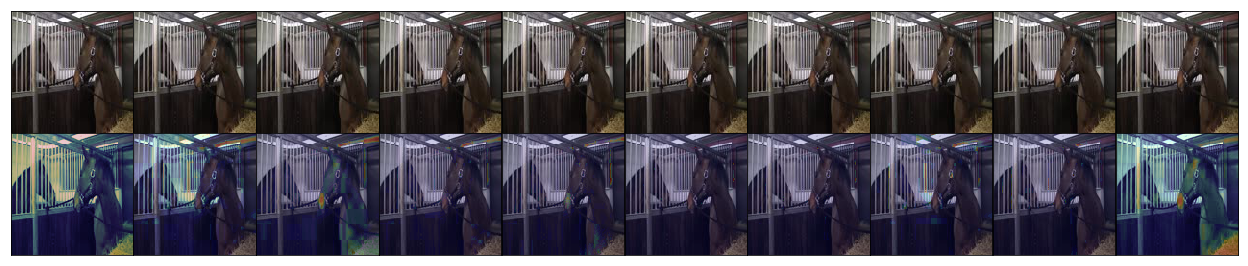

In [77]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
run_on_one_sequence(sess, model, batch_img)

Chose subject  1
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_2b/frame_000331.jpg     0
1  data/jpg_128_128_2fps/horse_2/2_2b/frame_000332.jpg     0
2  data/jpg_128_128_2fps/horse_2/2_2b/frame_000333.jpg     0
3  data/jpg_128_128_2fps/horse_2/2_2b/frame_000334.jpg     0
4  data/jpg_128_128_2fps/horse_2/2_2b/frame_000335.jpg     0
5  data/jpg_128_128_2fps/horse_2/2_2b/frame_000336.jpg     0
6  data/jpg_128_128_2fps/horse_2/2_2b/frame_000337.jpg     0
7  data/jpg_128_128_2fps/horse_2/2_2b/frame_000338.jpg     0
8  data/jpg_128_128_2fps/horse_2/2_2b/frame_000339.jpg     0
9  data/jpg_128_128_2fps/horse_2/2_2b/frame_000340.jpg     0
[[[0.9911396  0.00523446]
  [0.9933977  0.00263435]
  [0.9948895  0.00217879]
  [0.994833   0.00331316]
  [0.9931531  0.00403782]
  [0.9969304  0.00185261]
  [0.99448085 0.00232056]
  [0.99519324 0.00206544]
  [0.9955937  0.00171118]
  [0.9940805  0.00186162]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/Documents/EquineML/painface-recognition/notebooks/utils.py:433: RuntimeWarning: invalid value encountered in true_divide
  img -= np.min(img)
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/numpy/core/_methods.py

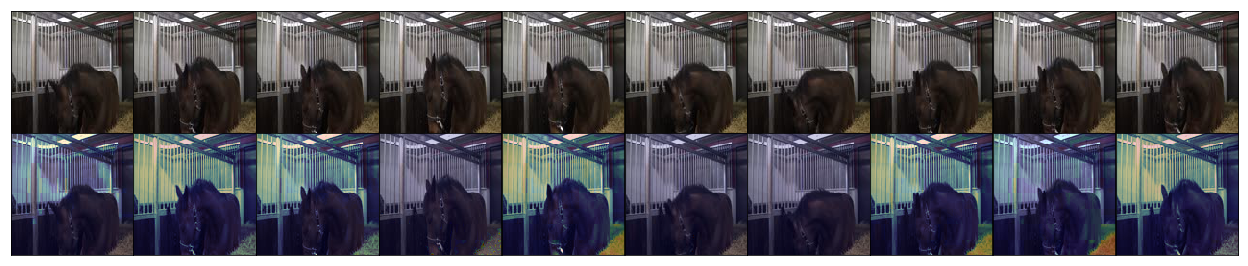

In [78]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
run_on_one_sequence(sess, model, batch_img)

Chose subject  1
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_1a/frame_001361.jpg     0
1  data/jpg_128_128_2fps/horse_2/2_1a/frame_001362.jpg     0
2  data/jpg_128_128_2fps/horse_2/2_1a/frame_001363.jpg     0
3  data/jpg_128_128_2fps/horse_2/2_1a/frame_001364.jpg     0
4  data/jpg_128_128_2fps/horse_2/2_1a/frame_001365.jpg     0
5  data/jpg_128_128_2fps/horse_2/2_1a/frame_001366.jpg     0
6  data/jpg_128_128_2fps/horse_2/2_1a/frame_001367.jpg     0
7  data/jpg_128_128_2fps/horse_2/2_1a/frame_001368.jpg     0
8  data/jpg_128_128_2fps/horse_2/2_1a/frame_001369.jpg     0
9  data/jpg_128_128_2fps/horse_2/2_1a/frame_001370.jpg     0
[[[0.93575174 0.04912998]
  [0.9711661  0.02288739]
  [0.97410315 0.01860308]
  [0.9770925  0.01984258]
  [0.9710471  0.01850024]
  [0.9725777  0.01734874]
  [0.9715803  0.02172167]
  [0.96862376 0.02446356]
  [0.963742   0.02441789]
  [0.9603171  0.03462386]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


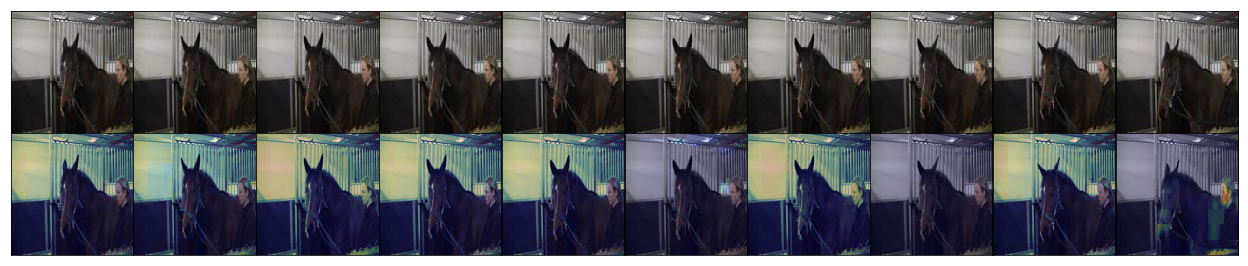

In [79]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
run_on_one_sequence(sess, model, batch_img)

Chose subject  1
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_1a/frame_000327.jpg     0
1  data/jpg_128_128_2fps/horse_2/2_1a/frame_000328.jpg     0
2  data/jpg_128_128_2fps/horse_2/2_1a/frame_000329.jpg     0
3  data/jpg_128_128_2fps/horse_2/2_1a/frame_000330.jpg     0
4  data/jpg_128_128_2fps/horse_2/2_1a/frame_000331.jpg     0
5  data/jpg_128_128_2fps/horse_2/2_1a/frame_000332.jpg     0
6  data/jpg_128_128_2fps/horse_2/2_1a/frame_000333.jpg     0
7  data/jpg_128_128_2fps/horse_2/2_1a/frame_000334.jpg     0
8  data/jpg_128_128_2fps/horse_2/2_1a/frame_000335.jpg     0
9  data/jpg_128_128_2fps/horse_2/2_1a/frame_000336.jpg     0
[[[0.93587697 0.06150338]
  [0.9504654  0.03757903]
  [0.9632625  0.0640391 ]
  [0.9736695  0.03049784]
  [0.97832125 0.03717447]
  [0.97455096 0.03296726]
  [0.9836121  0.04807465]
  [0.9840307  0.03780657]
  [0.98614687 0.0277766 ]
  [0.9861471  0.02239142]]]


/Users/sbroome/Documents/EquineML/painface-recognition/notebooks/utils.py:433: RuntimeWarning: invalid value encountered in true_divide
  img -= np.min(img)
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/numpy/core/_methods.py

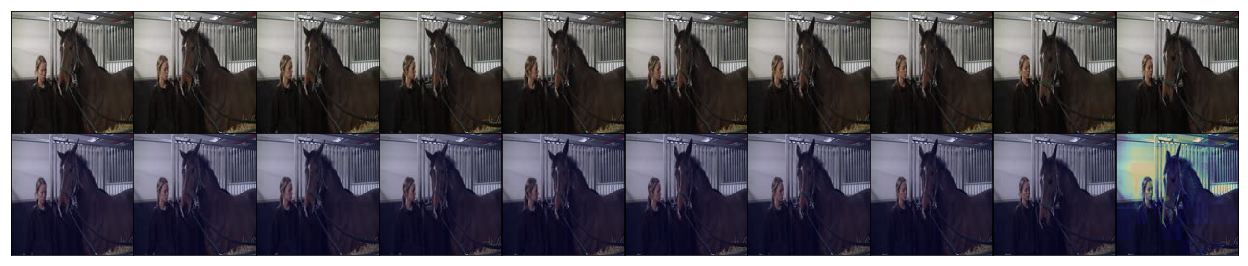

In [80]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
run_on_one_sequence(sess, model, batch_img)

Chose subject  1
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_2a/frame_001035.jpg     0
1  data/jpg_128_128_2fps/horse_2/2_2a/frame_001036.jpg     0
2  data/jpg_128_128_2fps/horse_2/2_2a/frame_001037.jpg     0
3  data/jpg_128_128_2fps/horse_2/2_2a/frame_001038.jpg     0
4  data/jpg_128_128_2fps/horse_2/2_2a/frame_001039.jpg     0
5  data/jpg_128_128_2fps/horse_2/2_2a/frame_001040.jpg     0
6  data/jpg_128_128_2fps/horse_2/2_2a/frame_001041.jpg     0
7  data/jpg_128_128_2fps/horse_2/2_2a/frame_001042.jpg     0
8  data/jpg_128_128_2fps/horse_2/2_2a/frame_001043.jpg     0
9  data/jpg_128_128_2fps/horse_2/2_2a/frame_001044.jpg     0
[[[0.99595535 0.01382968]
  [0.99834466 0.00861807]
  [0.99896    0.00584413]
  [0.99908173 0.00382578]
  [0.9990995  0.00544097]
  [0.99922836 0.00526042]
  [0.9984596  0.00632694]
  [0.99930227 0.00256535]
  [0.99869543 0.00288723]
  [0.99881184 0.00240942]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/Documents/EquineML/painface-recognition/notebooks/utils.py:433: RuntimeWarning: invalid value encountered in true_divide
  img -= np.min(img)
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/numpy/core/_methods.py

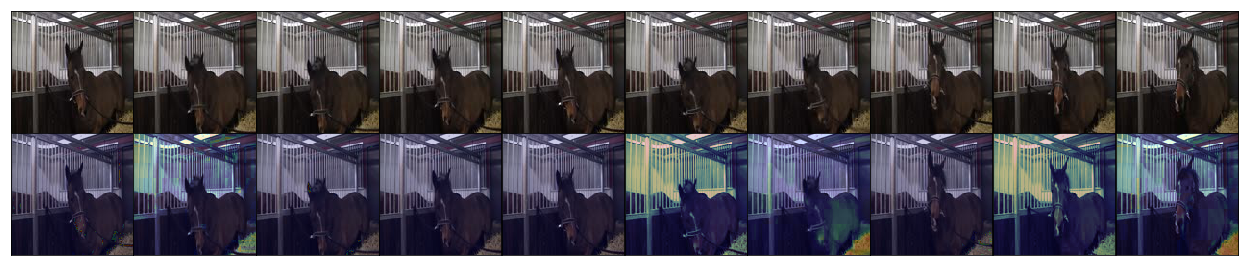

In [81]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
run_on_one_sequence(sess, model, batch_img)

Chose subject  1
                                                 Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_4/frame_000541.jpg     1
1  data/jpg_128_128_2fps/horse_2/2_4/frame_000542.jpg     1
2  data/jpg_128_128_2fps/horse_2/2_4/frame_000543.jpg     1
3  data/jpg_128_128_2fps/horse_2/2_4/frame_000544.jpg     1
4  data/jpg_128_128_2fps/horse_2/2_4/frame_000545.jpg     1
5  data/jpg_128_128_2fps/horse_2/2_4/frame_000546.jpg     1
6  data/jpg_128_128_2fps/horse_2/2_4/frame_000547.jpg     1
7  data/jpg_128_128_2fps/horse_2/2_4/frame_000548.jpg     1
8  data/jpg_128_128_2fps/horse_2/2_4/frame_000549.jpg     1
9  data/jpg_128_128_2fps/horse_2/2_4/frame_000550.jpg     1
[[[0.4992021  0.4365199 ]
  [0.15092477 0.92103004]
  [0.10414063 0.9489586 ]
  [0.04576984 0.9730056 ]
  [0.13403507 0.9668323 ]
  [0.06571864 0.9733353 ]
  [0.06015656 0.9852887 ]
  [0.08346434 0.95706064]
  [0.09122165 0.9508723 ]
  [0.06712087 0.9623303 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


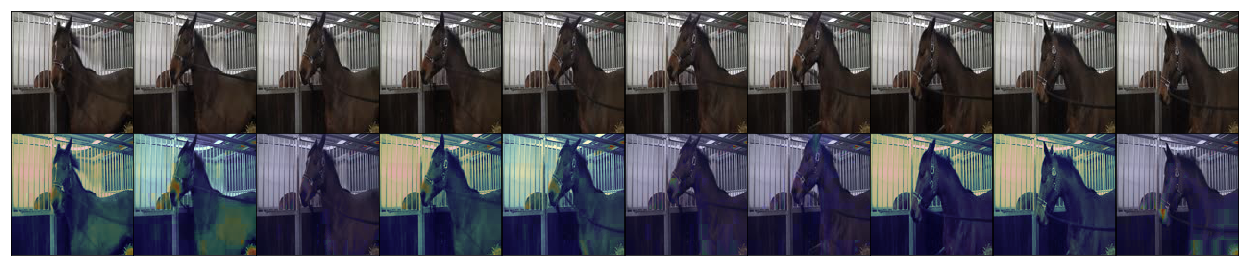

In [82]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
run_on_one_sequence(sess, model, batch_img)

Chose subject  1
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_2a/frame_002479.jpg     0
1  data/jpg_128_128_2fps/horse_2/2_2a/frame_002480.jpg     0
2  data/jpg_128_128_2fps/horse_2/2_2a/frame_002481.jpg     0
3  data/jpg_128_128_2fps/horse_2/2_2a/frame_002482.jpg     0
4  data/jpg_128_128_2fps/horse_2/2_2a/frame_002483.jpg     0
5  data/jpg_128_128_2fps/horse_2/2_2a/frame_002484.jpg     0
6  data/jpg_128_128_2fps/horse_2/2_2a/frame_002485.jpg     0
7  data/jpg_128_128_2fps/horse_2/2_2a/frame_002486.jpg     0
8  data/jpg_128_128_2fps/horse_2/2_2a/frame_002487.jpg     0
9  data/jpg_128_128_2fps/horse_2/2_2a/frame_002488.jpg     0
[[[0.99596834 0.00613534]
  [0.99800485 0.00262749]
  [0.9983814  0.00201662]
  [0.9985991  0.001862  ]
  [0.99857044 0.00226776]
  [0.99851435 0.00202439]
  [0.99902487 0.00151268]
  [0.9988663  0.00175896]
  [0.9988017  0.00189102]
  [0.99900144 0.00246556]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/Documents/EquineML/painface-recognition/notebooks/utils.py:433: RuntimeWarning: invalid value encountered in true_divide
  img -= np.min(img)
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/numpy/core/_methods.py

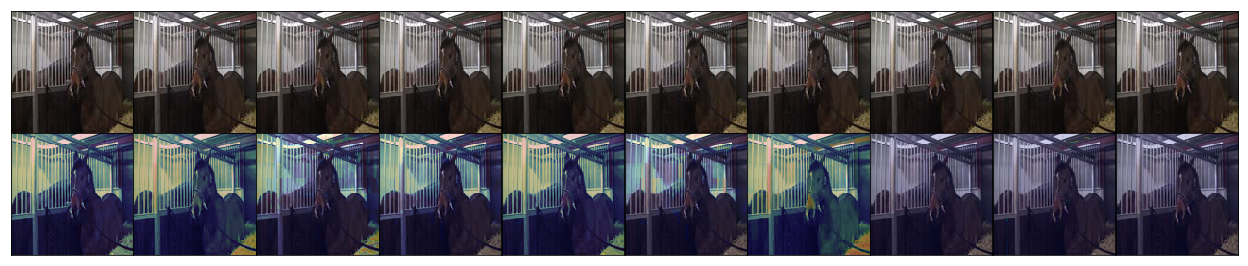

In [83]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
run_on_one_sequence(sess, model, batch_img)

Chose subject  1
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000035.jpg     1
1  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000036.jpg     1
2  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000037.jpg     1
3  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000038.jpg     1
4  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000039.jpg     1
5  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000040.jpg     1
6  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000041.jpg     1
7  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000042.jpg     1
8  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000043.jpg     1
9  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000044.jpg     1
[[[3.7510421e-03 9.9592787e-01]
  [1.0702417e-03 9.9868935e-01]
  [8.3036424e-04 9.9937952e-01]
  [5.5829633e-04 9.9964762e-01]
  [5.2969047e-04 9.9970442e-01]
  [6.4012723e-04 9.9973971e-01]
  [5.2286859e-04 9.9983168e-01]
  [4.9098744e-04 9.9971431e-01]
  [3.4469872e-04 9.9979967e-01]
  

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


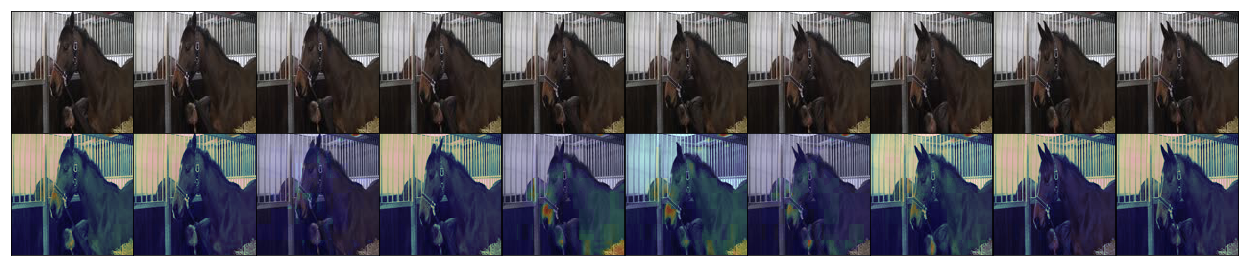

In [84]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
run_on_one_sequence(sess, model, batch_img)

Chose subject  1
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_2a/frame_002232.jpg     0
1  data/jpg_128_128_2fps/horse_2/2_2a/frame_002233.jpg     0
2  data/jpg_128_128_2fps/horse_2/2_2a/frame_002234.jpg     0
3  data/jpg_128_128_2fps/horse_2/2_2a/frame_002235.jpg     0
4  data/jpg_128_128_2fps/horse_2/2_2a/frame_002236.jpg     0
5  data/jpg_128_128_2fps/horse_2/2_2a/frame_002237.jpg     0
6  data/jpg_128_128_2fps/horse_2/2_2a/frame_002238.jpg     0
7  data/jpg_128_128_2fps/horse_2/2_2a/frame_002239.jpg     0
8  data/jpg_128_128_2fps/horse_2/2_2a/frame_002240.jpg     0
9  data/jpg_128_128_2fps/horse_2/2_2a/frame_002241.jpg     0
[[[0.99528545 0.01125462]
  [0.9984816  0.00476668]
  [0.998934   0.0039448 ]
  [0.9991135  0.00284161]
  [0.99915934 0.00310061]
  [0.99930596 0.00222336]
  [0.999363   0.00313911]
  [0.99919397 0.00310113]
  [0.9987423  0.00383602]
  [0.99824524 0.00818038]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


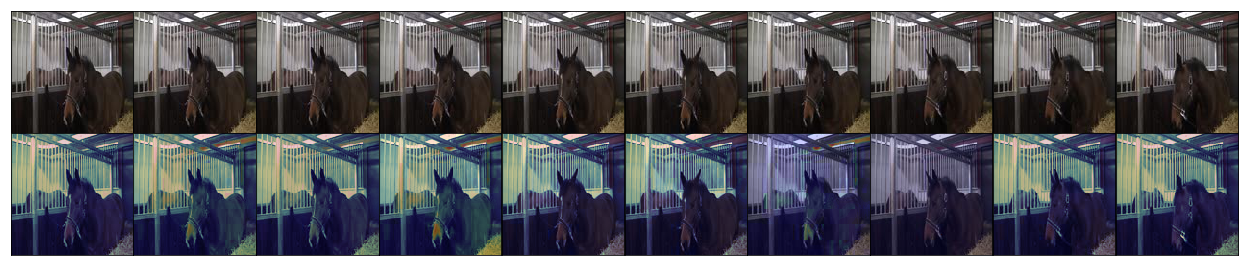

In [85]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
run_on_one_sequence(sess, model, batch_img)

Chose subject  1
Start index in subject dataframe:  7844
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000467.jpg     1
1  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000468.jpg     1
2  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000469.jpg     1
3  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000470.jpg     1
4  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000471.jpg     1
5  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000472.jpg     1
6  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000473.jpg     1
7  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000474.jpg     1
8  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000475.jpg     1
9  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000476.jpg     1
[[[3.0564549e-03 9.9685574e-01]
  [1.0707944e-03 9.9942529e-01]
  [7.6245121e-04 9.9941313e-01]
  [7.9805171e-04 9.9942517e-01]
  [8.5868535e-04 9.9944991e-01]
  [6.9012441e-04 9.9944979e-01]
  [7.2283740e-04 9.9942505e-01]
  [6.8938092e-04 9.9951148

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


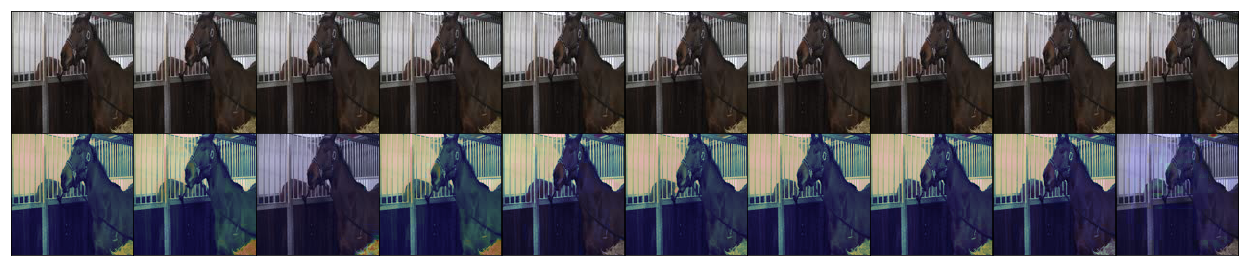

In [16]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
run_on_one_sequence(sess, model, batch_img)

Chose subject  1
Start index in subject dataframe:  10287
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_3b_1/frame_000090.jpg     1
1  data/jpg_128_128_2fps/horse_2/2_3b_1/frame_000091.jpg     1
2  data/jpg_128_128_2fps/horse_2/2_3b_1/frame_000092.jpg     1
3  data/jpg_128_128_2fps/horse_2/2_3b_1/frame_000093.jpg     1
4  data/jpg_128_128_2fps/horse_2/2_3b_1/frame_000094.jpg     1
5  data/jpg_128_128_2fps/horse_2/2_3b_1/frame_000095.jpg     1
6  data/jpg_128_128_2fps/horse_2/2_3b_1/frame_000096.jpg     1
7  data/jpg_128_128_2fps/horse_2/2_3b_1/frame_000097.jpg     1
8  data/jpg_128_128_2fps/horse_2/2_3b_1/frame_000098.jpg     1
9  data/jpg_128_128_2fps/horse_2/2_3b_1/frame_000099.jpg     1
[[[2.0285076e-03 9.9840742e-01]
  [7.6844310e-04 9.9961960e-01]
  [7.9615961e-04 9.9871671e-01]
  [4.9598794e-04 9.9940693e-01]
  [9.7625225e-04 9.9978524e-01]
  [6.5002305e-04 9.9972969e-01]
  [3.0270490e-04 9.9974245e-01]
  [1.4184917e-04 9.998261

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/Documents/EquineML/painface-recognition/notebooks/utils.py:434: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / np.max(cam) # scale 0 to 1.0
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/

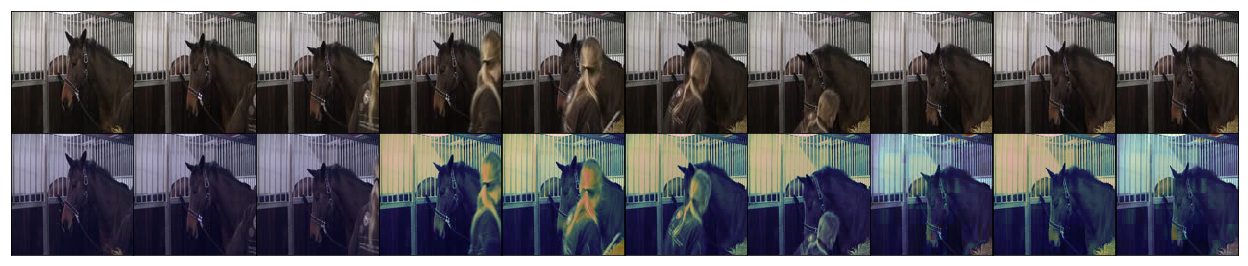

In [15]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
run_on_one_sequence(sess, model, batch_img)

Chose subject  1
Start index in subject dataframe:  4370
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_2a/frame_000615.jpg     0
1  data/jpg_128_128_2fps/horse_2/2_2a/frame_000616.jpg     0
2  data/jpg_128_128_2fps/horse_2/2_2a/frame_000617.jpg     0
3  data/jpg_128_128_2fps/horse_2/2_2a/frame_000618.jpg     0
4  data/jpg_128_128_2fps/horse_2/2_2a/frame_000619.jpg     0
5  data/jpg_128_128_2fps/horse_2/2_2a/frame_000620.jpg     0
6  data/jpg_128_128_2fps/horse_2/2_2a/frame_000621.jpg     0
7  data/jpg_128_128_2fps/horse_2/2_2a/frame_000622.jpg     0
8  data/jpg_128_128_2fps/horse_2/2_2a/frame_000623.jpg     0
9  data/jpg_128_128_2fps/horse_2/2_2a/frame_000624.jpg     0
[[[0.98860884 0.00973696]
  [0.9975442  0.00335425]
  [0.99804664 0.00214978]
  [0.99825186 0.00224442]
  [0.9981364  0.00170717]
  [0.9978022  0.00177724]
  [0.9981785  0.00128112]
  [0.9982779  0.00133067]
  [0.99823415 0.00149344]
  [0.9986879  0.00171703]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


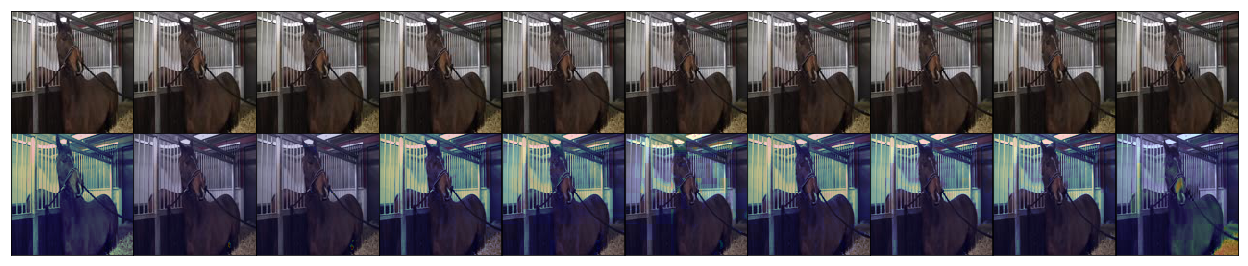

In [17]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
run_on_one_sequence(sess, model, batch_img)

Chose subject  1
Start index in subject dataframe:  8610
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_001233.jpg     1
1  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_001234.jpg     1
2  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_001235.jpg     1
3  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_001236.jpg     1
4  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_001237.jpg     1
5  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_001238.jpg     1
6  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_001239.jpg     1
7  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_001240.jpg     1
8  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_001241.jpg     1
9  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_001242.jpg     1
[[[1.1496614e-03 9.9858910e-01]
  [3.0264255e-04 9.9952006e-01]
  [1.9858580e-04 9.9976271e-01]
  [2.4469759e-04 9.9975520e-01]
  [1.4517918e-04 9.9979573e-01]
  [1.8717226e-04 9.9979323e-01]
  [1.7675593e-04 9.9977595e-01]
  [1.4172602e-04 9.9975795

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


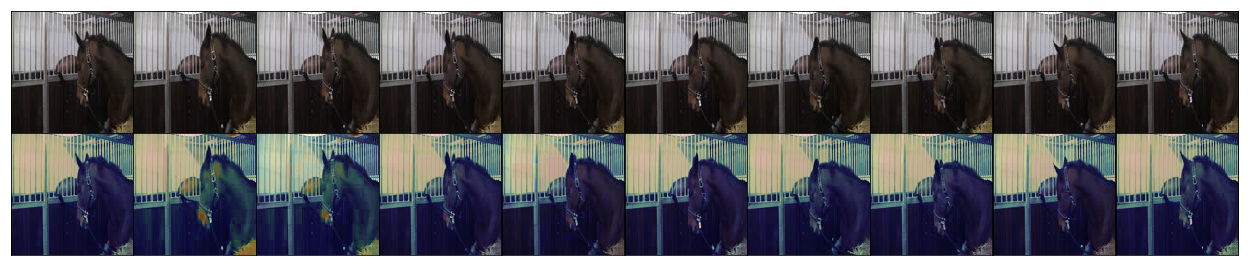

In [18]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
run_on_one_sequence(sess, model, batch_img)

Chose subject  1
Start index in subject dataframe:  11593
                                                 Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_4/frame_000916.jpg     1
1  data/jpg_128_128_2fps/horse_2/2_4/frame_000917.jpg     1
2  data/jpg_128_128_2fps/horse_2/2_4/frame_000918.jpg     1
3  data/jpg_128_128_2fps/horse_2/2_4/frame_000919.jpg     1
4  data/jpg_128_128_2fps/horse_2/2_4/frame_000920.jpg     1
5  data/jpg_128_128_2fps/horse_2/2_4/frame_000921.jpg     1
6  data/jpg_128_128_2fps/horse_2/2_4/frame_000922.jpg     1
7  data/jpg_128_128_2fps/horse_2/2_4/frame_000923.jpg     1
8  data/jpg_128_128_2fps/horse_2/2_4/frame_000924.jpg     1
9  data/jpg_128_128_2fps/horse_2/2_4/frame_000925.jpg     1
[[[0.16665168 0.9095297 ]
  [0.09642674 0.9463821 ]
  [0.06886347 0.9810033 ]
  [0.07886413 0.9361012 ]
  [0.03709684 0.9781964 ]
  [0.04265867 0.97268695]
  [0.04936259 0.9706925 ]
  [0.04114102 0.9787859 ]
  [0.06976982 0.9743026 ]
  [0.05914241 0.9814461 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


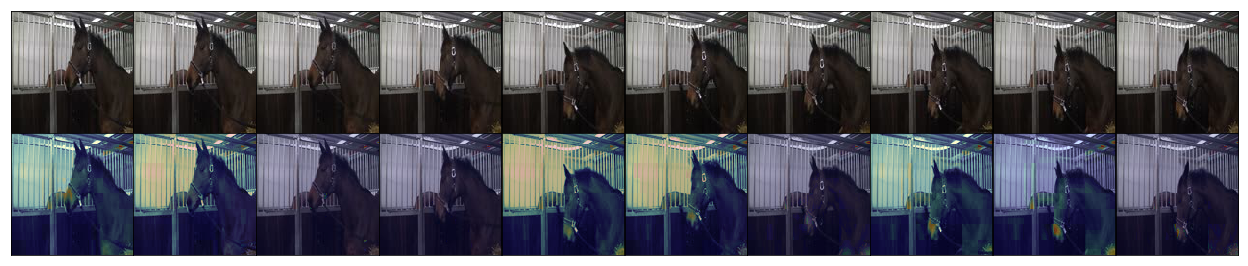

In [19]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
run_on_one_sequence(sess, model, batch_img)

Chose subject  1
Start index in subject dataframe:  11002
                                                 Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_4/frame_000325.jpg     1
1  data/jpg_128_128_2fps/horse_2/2_4/frame_000326.jpg     1
2  data/jpg_128_128_2fps/horse_2/2_4/frame_000327.jpg     1
3  data/jpg_128_128_2fps/horse_2/2_4/frame_000328.jpg     1
4  data/jpg_128_128_2fps/horse_2/2_4/frame_000329.jpg     1
5  data/jpg_128_128_2fps/horse_2/2_4/frame_000330.jpg     1
6  data/jpg_128_128_2fps/horse_2/2_4/frame_000331.jpg     1
7  data/jpg_128_128_2fps/horse_2/2_4/frame_000332.jpg     1
8  data/jpg_128_128_2fps/horse_2/2_4/frame_000333.jpg     1
9  data/jpg_128_128_2fps/horse_2/2_4/frame_000334.jpg     1
[[[0.11124332 0.9327526 ]
  [0.11820874 0.93431115]
  [0.17064588 0.9155643 ]
  [0.25150788 0.83767784]
  [0.1460398  0.94047076]
  [0.17254376 0.94794124]
  [0.1335919  0.95905626]
  [0.19448291 0.90730125]
  [0.09385028 0.9170724 ]
  [0.17284621 0.9213331 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


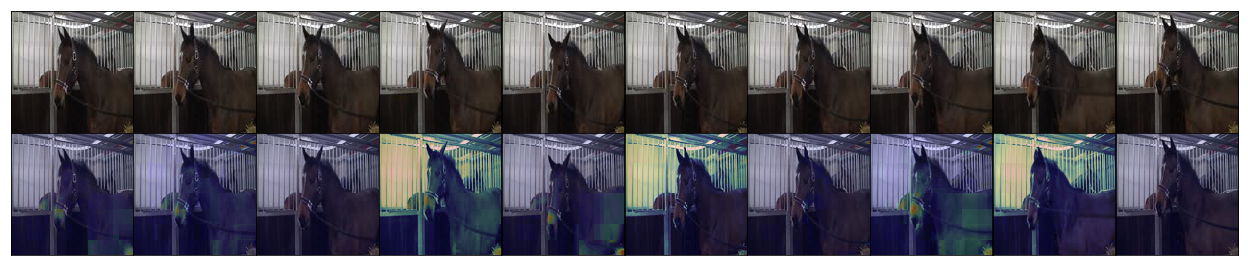

In [20]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
run_on_one_sequence(sess, model, batch_img)

Chose subject  1
Start index in subject dataframe:  4906
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_2a/frame_001151.jpg     0
1  data/jpg_128_128_2fps/horse_2/2_2a/frame_001152.jpg     0
2  data/jpg_128_128_2fps/horse_2/2_2a/frame_001153.jpg     0
3  data/jpg_128_128_2fps/horse_2/2_2a/frame_001154.jpg     0
4  data/jpg_128_128_2fps/horse_2/2_2a/frame_001155.jpg     0
5  data/jpg_128_128_2fps/horse_2/2_2a/frame_001156.jpg     0
6  data/jpg_128_128_2fps/horse_2/2_2a/frame_001157.jpg     0
7  data/jpg_128_128_2fps/horse_2/2_2a/frame_001158.jpg     0
8  data/jpg_128_128_2fps/horse_2/2_2a/frame_001159.jpg     0
9  data/jpg_128_128_2fps/horse_2/2_2a/frame_001160.jpg     0
[[[0.9939957  0.005631  ]
  [0.9981927  0.00217208]
  [0.99847597 0.00166934]
  [0.9986546  0.0019208 ]
  [0.9991009  0.00123013]
  [0.9993586  0.0010747 ]
  [0.99874747 0.00133431]
  [0.9979785  0.0011081 ]
  [0.99763894 0.00127381]
  [0.9979741  0.00139814]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


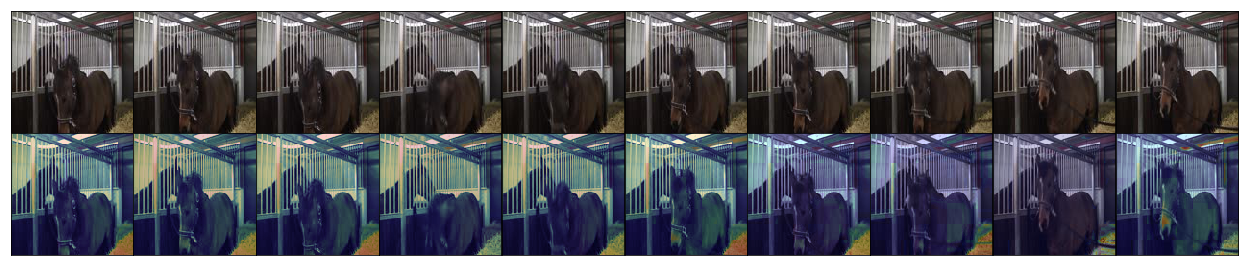

In [21]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=1)
run_on_one_sequence(sess, model, batch_img)